In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler

%matplotlib inline

# Data Wrangling and Exploration

In [2]:
# Full path of the 'orders' dataset
orders_file = 'https://www.dropbox.com/s/ej64qorm1uvmjlp/olist_orders_dataset.csv?dl=1'

# Full path of the 'customer' dataset
cust_file = 'https://www.dropbox.com/s/t082qlggu4wxiq5/olist_customers_dataset.csv?dl=1'

# File output location
out = r"C:\Users\scheerja\Downloads"

In [3]:
#read into dataframes
def read_olist_data(file1, file2):
    
    # Read the orders data
    orders = pd.read_csv(file1)

    print (f'{len(orders):,d} read from the orders file.')

    # Drop unnecessary columns
    drop_vars = ['order_delivered_carrier_date']

    orders = orders.drop(drop_vars, axis=1)

    # Date-time conversion
    orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
    orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
    orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
    orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])

    # Let's convert the order purchase timestamps into dates
    orders['order_purchase_date'] = orders['order_purchase_timestamp'].dt.date

    # Extract month from the order date
    orders['order_month'] = orders['order_purchase_timestamp'].dt.month

    # Read the file that contains the unique customer identifier
    cust = pd.read_csv(file2)

    print (f'{len(cust):,d} read from the customer file.')

    # Let's keep only the following two columns: customer_id, customer_unique_id
    cust = cust[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']]

    # Merge orders and cust dataframes
    orders = pd.merge(orders, cust, on='customer_id', how='inner')
    
    print (f'{len(orders):,d} records in the output  file.')
    
    return orders

orders = read_olist_data(orders_file, cust_file)

orders.head()

99,441 read from the orders file.
99,441 read from the customer file.
99,441 records in the output  file.


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_date,order_month,customer_unique_id,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,2017-10-02,10,7c396fd4830fd04220f754e42b4e5bff,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,2018-07-24,7,af07308b275d755c9edb36a90c618231,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04,2018-08-08,8,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15,2017-11-18,11,7c142cf63193a1473d2e66489a9ae977,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26,2018-02-13,2,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,SP


Text(0.5, 0, 'Order Purchase Day')

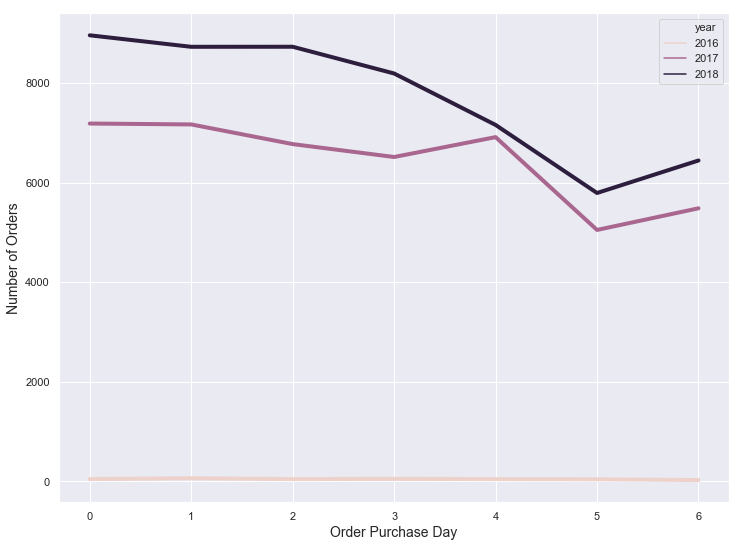

In [4]:
orders['year'] = orders['order_purchase_timestamp'].dt.year 
orders['weekday'] = orders['order_purchase_timestamp'].dt.dayofweek
orders_ct = orders.groupby(['year', 'weekday'])['order_id'].count().reset_index()
sns.set(style='darkgrid')
plt.figure(figsize=[12, 9])
sns.lineplot(x='weekday', y='order_id', lw=4,
            hue='year', data=orders_ct)
plt.ylabel('Number of Orders', fontsize=14)
plt.xlabel('Order Purchase Day', fontsize=14)


Above we can see that generally sales were best at the beginning of the work week - they tend to slow down as the weekend approaches, then pick back up when at the end. It's also worth noting how low the sales are in the year 2016, when the company first started.

# Prediction Window

In [5]:
#subset data prior to prediction window
print (len(orders))

# Select data prior to the prediction window
snapshot_date = date(2018, 2, 28)

attr_raw = orders[orders['order_purchase_timestamp'].dt.date <= snapshot_date]

len(orders), len(attr_raw)

99441


(99441, 59427)

# Feature Creation

In [6]:
#create customer recency feature
cust_recency = attr_raw.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()

snapshot_date = date(2018, 7, 31)

delta = snapshot_date - cust_recency.order_purchase_timestamp.dt.date

cust_recency['order_recency'] = delta.dt.days
cust_recency = cust_recency.drop('order_purchase_timestamp', axis=1)

#create total orders feature
cust_orders = orders.groupby('customer_unique_id').size().reset_index()

cust_orders = cust_orders.rename(columns={0: 'total_orders'})

#merge total orders and recency
attr = pd.merge(cust_recency, cust_orders, on='customer_unique_id', how='left')
attr.head()



,customer_unique_id,order_recency,total_orders
0,0000f46a3911fa3c0805444483337064,508,1
1,0000f6ccb0745a6a4b88665a16c9f078,292,1
2,0004aac84e0df4da2b147fca70cf8255,259,1
3,00053a61a98854899e70ed204dd4bafe,153,1
4,0005e1862207bf6ccc02e4228effd9a0,514,1


In [7]:
#create average delivery delta feature - time difference between estimated and actual delivery date
attr_raw['avg_delivery_delta'] = attr_raw.order_estimated_delivery_date.dt.date - attr_raw.order_delivered_customer_date.dt.date
attr_raw['avg_delivery_delta_days'] = attr_raw['avg_delivery_delta'].dt.days
cust_delivery = attr_raw.groupby('customer_unique_id')['avg_delivery_delta_days'].mean().reset_index()
#merge
attr1 = pd.merge(attr, cust_delivery, on='customer_unique_id', how='left')
attr1.head()




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,customer_unique_id,order_recency,total_orders,avg_delivery_delta_days
0,0000f46a3911fa3c0805444483337064,508,1,2.0
1,0000f6ccb0745a6a4b88665a16c9f078,292,1,12.0
2,0004aac84e0df4da2b147fca70cf8255,259,1,8.0
3,00053a61a98854899e70ed204dd4bafe,153,1,10.0
4,0005e1862207bf6ccc02e4228effd9a0,514,1,28.0


In [8]:
#create average order to approval time feature - time from customer order to approval timestamp

attr_raw['avg_order_to_approval_time'] = attr_raw.order_approved_at.dt.date - attr_raw.order_purchase_timestamp.dt.date
attr_raw['avg_order_to_approval_time'] = attr_raw['avg_order_to_approval_time'].dt.days
order_approval_time = attr_raw.groupby('customer_unique_id')['avg_order_to_approval_time'].mean().reset_index()
#merge
attr2 = pd.merge(attr1, order_approval_time, on='customer_unique_id', how='left')
attr2.head()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,customer_unique_id,order_recency,total_orders,avg_delivery_delta_days,avg_order_to_approval_time
0,0000f46a3911fa3c0805444483337064,508,1,2.0,0.0
1,0000f6ccb0745a6a4b88665a16c9f078,292,1,12.0,0.0
2,0004aac84e0df4da2b147fca70cf8255,259,1,8.0,0.0
3,00053a61a98854899e70ed204dd4bafe,153,1,10.0,0.0
4,0005e1862207bf6ccc02e4228effd9a0,514,1,28.0,0.0


In [9]:
#create proportion of orders fulfilled feature - % of customer's orders with 'delivered' order status
attr_raw['order_delivered'] = np.where(attr_raw['order_status'].str.contains("delivered", case=False, na=False), 1, 0)
delivered_total = attr_raw.groupby('customer_unique_id')['order_delivered'].sum().reset_index()
#merge
attr3 = pd.merge(attr2, delivered_total, on='customer_unique_id', how='left')
#create proportion from total
attr3['order_proportion_delivered'] = attr3.order_delivered / attr3.total_orders
attr3 = attr3.drop('order_delivered', axis = 1)




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
type(cust_id)

pandas.core.series.Series

In [14]:
#create dummy variables for customer state
orders_state = attr_raw[['customer_unique_id', 'customer_state']]
cust_id = attr_raw.customer_unique_id.reset_index()
state_dum = pd.get_dummies(orders_state.customer_state)
state_dum = pd.merge(cust_id, state_dum, on=cust_id.index)
state_dum = state_dum.drop('key_0', axis=1)
state = state_dum.groupby('customer_unique_id').sum()
attr4 = pd.merge(attr3, state, on='customer_unique_id', how='left')
#completed dataset with 5 attributes
attributes = attr4
attributes.head()


,customer_unique_id,order_recency,total_orders,avg_delivery_delta_days,avg_order_to_approval_time,order_proportion_delivered,index,AC,AL,AM,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,0000f46a3911fa3c0805444483337064,508,1,2.0,0.0,1.0,26460,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0000f6ccb0745a6a4b88665a16c9f078,292,1,12.0,0.0,1.0,98493,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0004aac84e0df4da2b147fca70cf8255,259,1,8.0,0.0,1.0,41564,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,00053a61a98854899e70ed204dd4bafe,153,1,10.0,0.0,1.0,6867,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0005e1862207bf6ccc02e4228effd9a0,514,1,28.0,0.0,1.0,71235,0,0,0,...,0,1,0,0,0,0,0,0,0,0


# Subsetting Target and Train/Test Split

In [15]:
#targeting


mask = (orders.order_purchase_timestamp.dt.year == 2018) & (orders.order_purchase_timestamp.dt.month == 3)

target_events_raw = orders[mask]

len(target_events_raw)

7211

In [16]:
print (target_events_raw['order_purchase_timestamp'].min(), target_events_raw['order_purchase_timestamp'].max())

2018-03-01 00:00:00 2018-03-31 23:54:10


In [17]:
target_events = target_events_raw.groupby('customer_unique_id').size().reset_index()

target_events.head()
len(target_events)

7115

In [18]:
df = pd.merge(attributes, target_events, how='left', on='customer_unique_id')

df = df.rename(columns={0: 'purch'})

df['purch'] = [1 if x >= 1 else 0 for x in df['purch']]



# Correlation and Imputation

In [19]:
#correlations

df[['order_recency', 'total_orders','avg_delivery_delta_days', 'avg_order_to_approval_time', 'order_proportion_delivered', 'purch']].corr()

,order_recency,total_orders,avg_delivery_delta_days,avg_order_to_approval_time,order_proportion_delivered,purch
order_recency,1.000000,-0.034159,0.201047,0.011516,-0.050249,-0.016843
total_orders,-0.034159,1.000000,0.013674,-0.004798,-0.136478,0.256306
avg_delivery_delta_days,0.201047,0.013674,1.000000,-0.054756,-0.004394,0.002814
avg_order_to_approval_time,0.011516,-0.004798,-0.054756,1.000000,-0.035193,-0.001486
order_proportion_delivered,-0.050249,-0.136478,-0.004394,-0.035193,1.000000,-0.126542
purch,-0.016843,0.256306,0.002814,-0.001486,-0.126542,1.000000


In [20]:
df.isna().sum()

customer_unique_id               0
order_recency                    0
total_orders                     0
avg_delivery_delta_days       1981
avg_order_to_approval_time      65
order_proportion_delivered       0
index                            0
AC                               0
AL                               0
AM                               0
AP                               0
BA                               0
CE                               0
DF                               0
ES                               0
GO                               0
MA                               0
MG                               0
MS                               0
MT                               0
PA                               0
PB                               0
PE                               0
PI                               0
PR                               0
RJ                               0
RN                               0
RO                               0
RR                  

In [21]:
#create new df with na values filled with zeros
df_fill = df
df_fill['avg_delivery_delta_days'] = df_fill['avg_delivery_delta_days'].fillna(0)
df_fill['avg_order_to_approval_time'] = df_fill['avg_order_to_approval_time'].fillna(0)

In [22]:
#correlations of filled df

df_fill[['order_recency', 'total_orders','avg_delivery_delta_days', 'avg_order_to_approval_time', 'order_proportion_delivered', 'purch']].corr()

#are the differences acceptible? I'm not really sure...

,order_recency,total_orders,avg_delivery_delta_days,avg_order_to_approval_time,order_proportion_delivered,purch
order_recency,1.000000,-0.034159,0.179542,0.011112,-0.050249,-0.016843
total_orders,-0.034159,1.000000,0.017890,-0.004741,-0.136478,0.256306
avg_delivery_delta_days,0.179542,0.017890,1.000000,-0.047142,0.199605,0.002366
avg_order_to_approval_time,0.011112,-0.004741,-0.047142,1.000000,-0.032992,-0.001462
order_proportion_delivered,-0.050249,-0.136478,0.199605,-0.032992,1.000000,-0.126542
purch,-0.016843,0.256306,0.002366,-0.001462,-0.126542,1.000000


In [23]:
#model/training setup

preds = ['order_recency', 'total_orders','avg_delivery_delta_days', 'avg_order_to_approval_time', 'order_proportion_delivered', 'SP', 'BA', 'GO', 'RN', 'PR', 'RS', 'RJ', 'MG', 'SC', 'RR', 'PE',
       'TO', 'CE', 'DF', 'SE', 'MT', 'PB', 'PA', 'RO', 'ES', 'AP', 'MS',
       'MA', 'PI', 'AL', 'AC', 'AM']

X = df_fill[preds]
y = df_fill['purch']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=314)

len(X_train), len(X_test)

(28755, 28755)

In [25]:
y_train.value_counts()

0    28678
1       77
Name: purch, dtype: int64

# Modeling and Validation

In [26]:
X_scaler = StandardScaler()

In [27]:
logit = LogisticRegression(solver='liblinear')

# Define the model object
logit.fit(X_scaler.fit_transform(X_train.astype(float)), y_train)

# Get model scores
logit_scores_train = logit.predict_proba(X_scaler.transform(X_train.astype(float)))[:, 1]
logit_scores_test = logit.predict_proba(X_scaler.transform(X_test.astype(float)))[:, 1]

# Calculate False Positive Rates and True Positive Rates
logit_fpr_train, logit_tpr_train, _ = roc_curve(y_train, logit_scores_train)
logit_fpr_test, logit_tpr_test, _ = roc_curve(y_test, logit_scores_test)

In [28]:
tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)

tree_scores_train = tree.predict_proba(X_train)[:, 1]
tree_scores_test = tree.predict_proba(X_test)[:, 1]

tree_fpr_train, tree_tpr_train, _ = roc_curve(y_train, tree_scores_train)
tree_fpr_test, tree_tpr_test, _ = roc_curve(y_test, tree_scores_test)


In [29]:
forest = RandomForestClassifier()

forest.fit(X_train, y_train)

forest_scores_train = forest.predict_proba(X_train)[:, 1]
forest_scores_test = forest.predict_proba(X_train)[:, 1]

forest_fpr_train, forest_tpr_train, _ = roc_curve(y_train, forest_scores_train)
forest_fpr_test, forest_tpr_test, _ = roc_curve(y_test, forest_scores_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


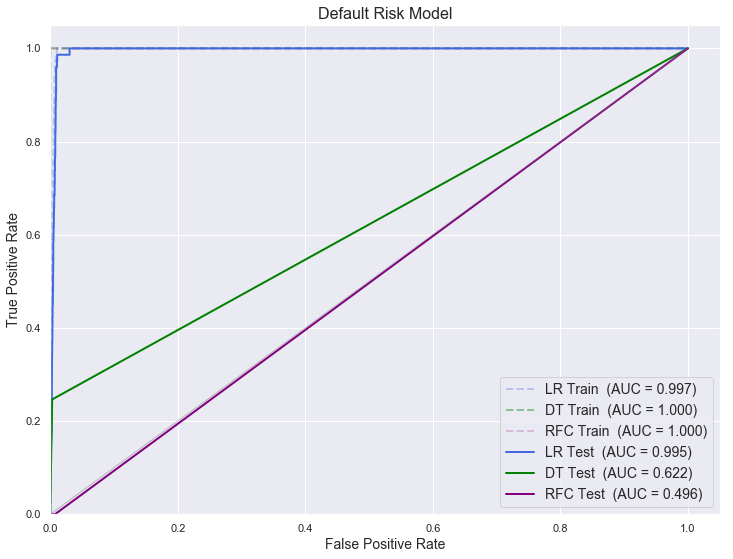

In [30]:
plt.figure().set_size_inches(12, 9)

plt.plot(logit_fpr_train, logit_tpr_train, color='royalblue', lw=2, alpha = 0.3, linestyle = '--',
         label='LR Train  (AUC = %0.3f)' %roc_auc_score(y_train, logit_scores_train))
plt.plot(tree_fpr_train, tree_tpr_train, color='green', lw=2, alpha = 0.4, linestyle = '--',
         label='DT Train  (AUC = %0.3f)' %roc_auc_score(y_train, tree_scores_train))
plt.plot(forest_fpr_train, forest_tpr_train, color='purple', lw=2, alpha = 0.2, linestyle = '--',
         label='RFC Train  (AUC = %0.3f)' %roc_auc_score(y_train, forest_scores_train))


plt.plot(logit_fpr_test, logit_tpr_test, color='royalblue', lw=2, linestyle = '-',
         label='LR Test  (AUC = %0.3f)' %roc_auc_score(y_test, logit_scores_test))
plt.plot(tree_fpr_test, tree_tpr_test, color='green', lw=2, linestyle = '-',
         label='DT Test  (AUC = %0.3f)' %roc_auc_score(y_test, tree_scores_test))
plt.plot(forest_fpr_test, forest_tpr_test, color='purple', lw=2, linestyle = '-',
         label='RFC Test  (AUC = %0.3f)' %roc_auc_score(y_test, forest_scores_test))

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='-', alpha=.5)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Default Risk Model', fontsize = 16)
plt.legend(loc="lower right", fontsize = 14)
plt.show()

In [31]:
#confusion matrix
def cmat(model):
    preds_test = model.predict(X_test)
    c = confusion_matrix(y_test, preds_test)
    return c

cmat(logit)


array([[28682,     0],
       [   73,     0]], dtype=int64)

In [32]:
cmat(tree)

array([[28594,    88],
       [   55,    18]], dtype=int64)

In [33]:
cmat(forest)

array([[28669,    13],
       [   67,     6]], dtype=int64)

In [34]:
#precision & recall
def prec_rec(model):
    preds_test = model.predict(X_test)
    prec = precision_score(y_test, preds_test)
    recall = recall_score(y_test, preds_test)
    return prec, recall
prec_rec(logit)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.0, 0.0)

In [35]:
prec_rec(tree)

(0.16981132075471697, 0.2465753424657534)

In [36]:
prec_rec(forest)

(0.3157894736842105, 0.0821917808219178)

In [37]:
#accuracy score
def acc(model):
    preds_test = model.predict(X_test)
    acc = accuracy_score(y_test, preds_test)
    return acc
acc(logit)

0.9974613110763345

In [38]:
acc(tree)

0.9950269518344635

In [39]:
acc(forest)

0.9972178751521474

# Conclusion

It seems that the models above are suffering greatly from overfitting as a result of the extreme imbalance in this dataset - less than 0.3% of the targets are positive (purchases). 

Because of the extreme imbalance in this dataset, under or oversampling did not seem like a good option.

While all the models have very high accuracy, the ROC curves indicate a serious problem with the decision tree and random forest classifiers - they had perfect accuracy on the training set but the DT's AUC was hardly better than a guess across the decision thresholds. The RFC's AUC was slightly *lower* than the baseline of 0.5.

Only the logistic regression model provided high AUC on both the training and testing set, so I would likely choose this model over the others. However, the LR model also returned no positive predictions - so it is still likely suffering from overfitting.

Given the imbalance, evaluating model performance is difficult and it is hard to say how these models would perform in a real world implementation.